# CS598PS - Problem Set 2

### Preliminaries

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from numpy import *
from matplotlib.pylab import *

# Some optional beautification
rcParams['figure.figsize'] = (12,6)
rcParams['lines.linewidth'] = 1
rcParams['image.cmap'] = 'Greys'
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.family'] = 'Avenir Next LT Pro'
rcParams['font.weight'] = 400
rcParams['xtick.color'] = '#222222'
rcParams['ytick.color'] = '#222222'
rcParams['grid.color'] = '#dddddd'
rcParams['grid.linestyle'] = '-'
rcParams['grid.linewidth'] = 0.5
rcParams['axes.titlesize'] = 11
rcParams['axes.titleweight'] = 600
rcParams['axes.labelsize'] = 10
rcParams['axes.labelweight'] = 400
rcParams['axes.linewidth'] = 0.5
rcParams['axes.edgecolor'] = [.25,.25,.25]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define all the decompositions

In [9]:
# Perform PCA by diagonalizing the covariance
def pca( x, k):
    from scipy.sparse.linalg import eigsh
    
    # Remove data mean
    xm = x - mean( x, axis=1, keepdims=True)

    # Get covariance estimate
    C = xm.dot( xm.T) / (xm.shape[1]-1)

    # Get top k PCA covariance eigenvectors/values
    v,u = eigsh( C, k=k)

    # Get overall transform and the input's projection to k dimensions
    w = diag( 1./sqrt(v)) @ u.T
    y = w @ xm

    return w,y

# Perform ICA using infomax (assumes white data)
def ica( x):
    D = x.shape[1]*eye( x.shape[0])
    w = eye( x.shape[0])
    for i in range( 500):
        y = w @ x
        dw = (D - 2*tanh( y) @ y.T) @ w
        w = w + .0001*dw

    return w,y

# Perform KL-NMF
def nmf( x, k):
    w = rand( x.shape[0], k)
    h = rand( k, x.shape[1])
    eps = 1e-6 # use this to avoid potential divisions by 0
    for i in range( 100):
        h = h * (w.T @ x) / (w.T @ w @ h+eps)
        w = w * (x @ h.T) / (w @ h @ h.T+eps)

    return w,h

## Problem 1

### Load the sound and plot it

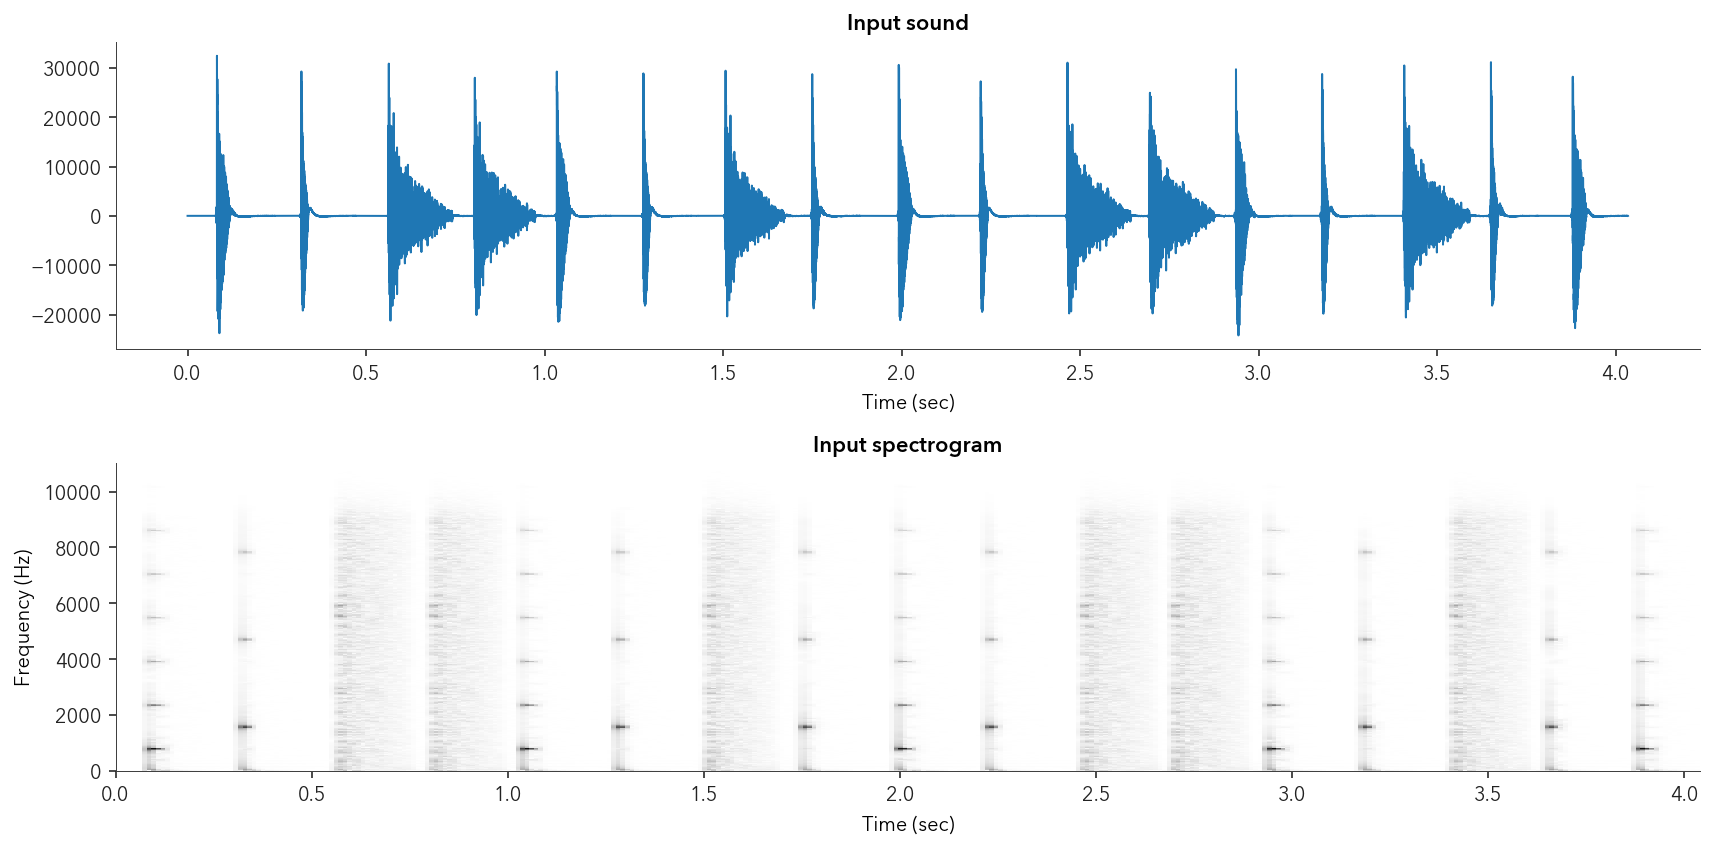

In [20]:
# Load the file and convert to floating point
import scipy.io.wavfile
fs,s = scipy.io.wavfile.read( 'data/vl1.wav')
s = s.astype( float64)
subplot( 2, 1, 1), plot( arange( 0, len( s))/fs, s)
title( 'Input sound'), xlabel( 'Time (sec)')

# Get the magnitude spectrogram
from scipy.signal import stft
q,t,f = stft( s, fs=fs, nperseg=1024, noverlap=768)
f = abs( f)
subplot( 2, 1, 2), pcolormesh( t, q, f**.5), title( 'Input spectrogram')
xlabel( 'Time (sec)'), ylabel( 'Frequency (Hz)')
tight_layout()

In the spectrogram we can see the three instruments clearly.  First we see the lower-frequency tone that has a spectrum with 6 peaks throughout the frequency spread.  It is followed by the higher-frequency tone that has a spectrum with three peaks.  The snare drum sound come next and has a wideband structure, meaning that it has a lot of energy throughout all the frequencies.  Because of that it looks more “cloudy”.  We can see these instruments repeating across the time axis as the drum loop is formed.

### Do PCA on the audio data

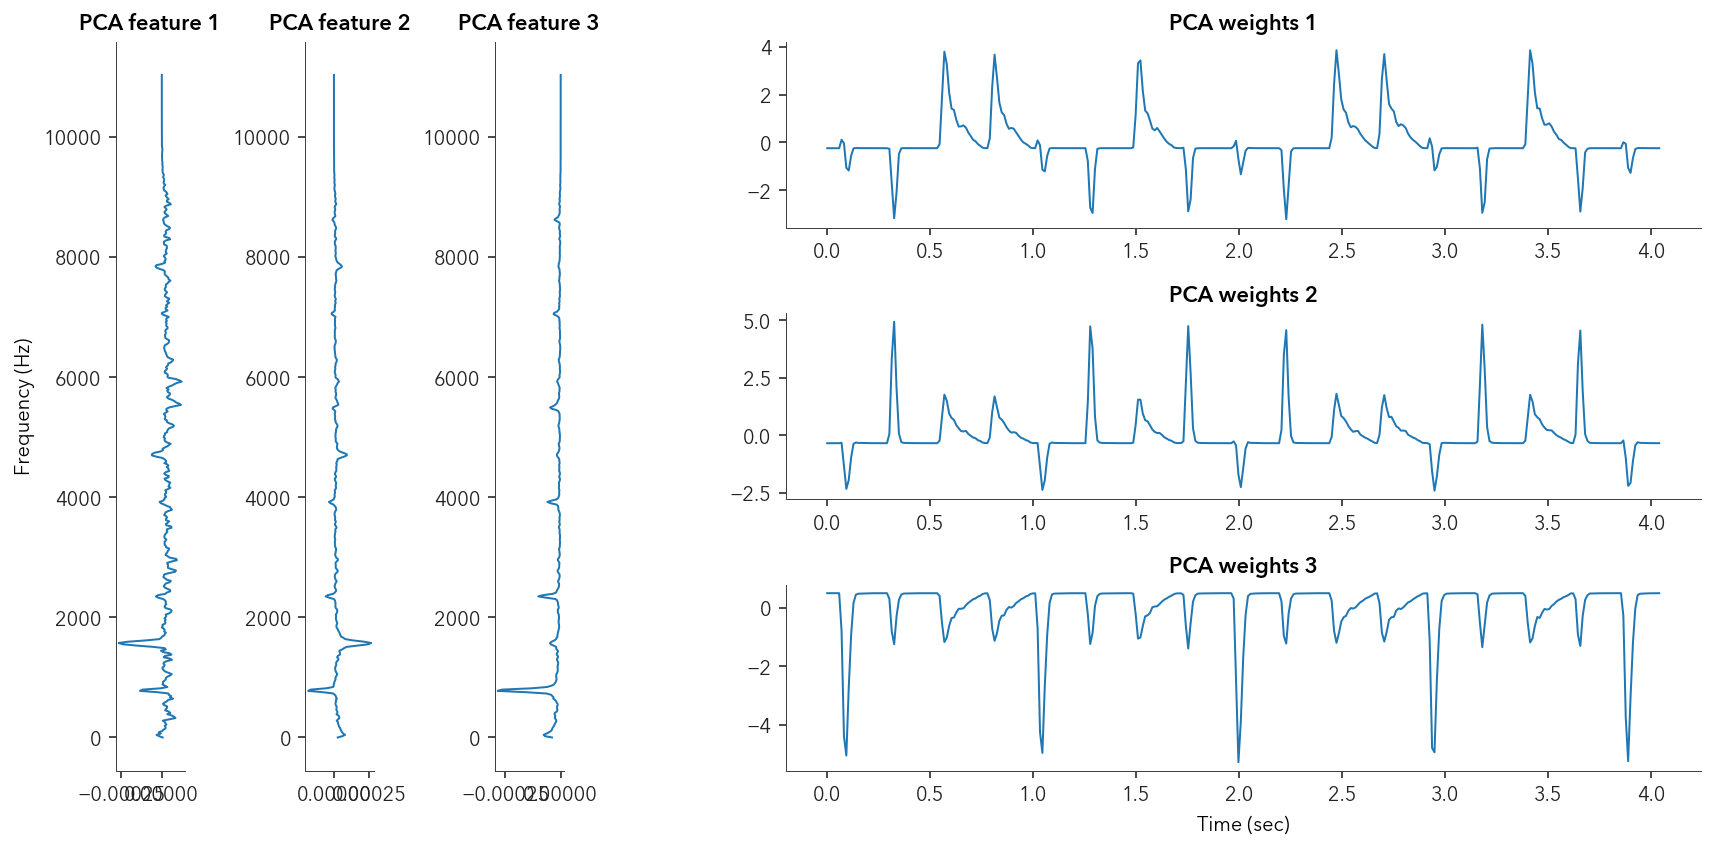

In [21]:
# Do it ...
wp,xp = pca( f, 3);

# Show me the eigenvectors
subplot2grid( (1,9), (0,0)), plot( wp[0], q), title( 'PCA feature 1'), ylabel( 'Frequency (Hz)')
subplot2grid( (1,9), (0,1)), plot( wp[1], q), title( 'PCA feature 2')
subplot2grid( (1,9), (0,2)), plot( wp[2], q), title( 'PCA feature 3')

# Show me the projection
subplot2grid( (3,3), (0,1), colspan=2), plot( t, xp[0]), title( 'PCA weights 1')
subplot2grid( (3,3), (1,1), colspan=2), plot( t, xp[1]), title( 'PCA weights 2')
subplot2grid( (3,3), (2,1), colspan=2), plot( t, xp[2]), title( 'PCA weights 3'), xlabel('Time (sec)')
tight_layout()

In the PCA features we see some elements of the spectra of the three instruments.  The third feature seems to be a sign-inverted representation of the low tone (the energies are negative as opposed to positive as we would prefer to perceive them).  The second feature seems to have be a mix of a sign-inverted low tone and the high tone.  The remmaining feature is sort-of the spectrum of the snare drum, but we also see the high tone and to a lesser degree the low tone both being mixed in and sign-inverted.  In the PCA weights we see some of the structure of the drum beat, but things are a little mixed together.

### Get the ICA features

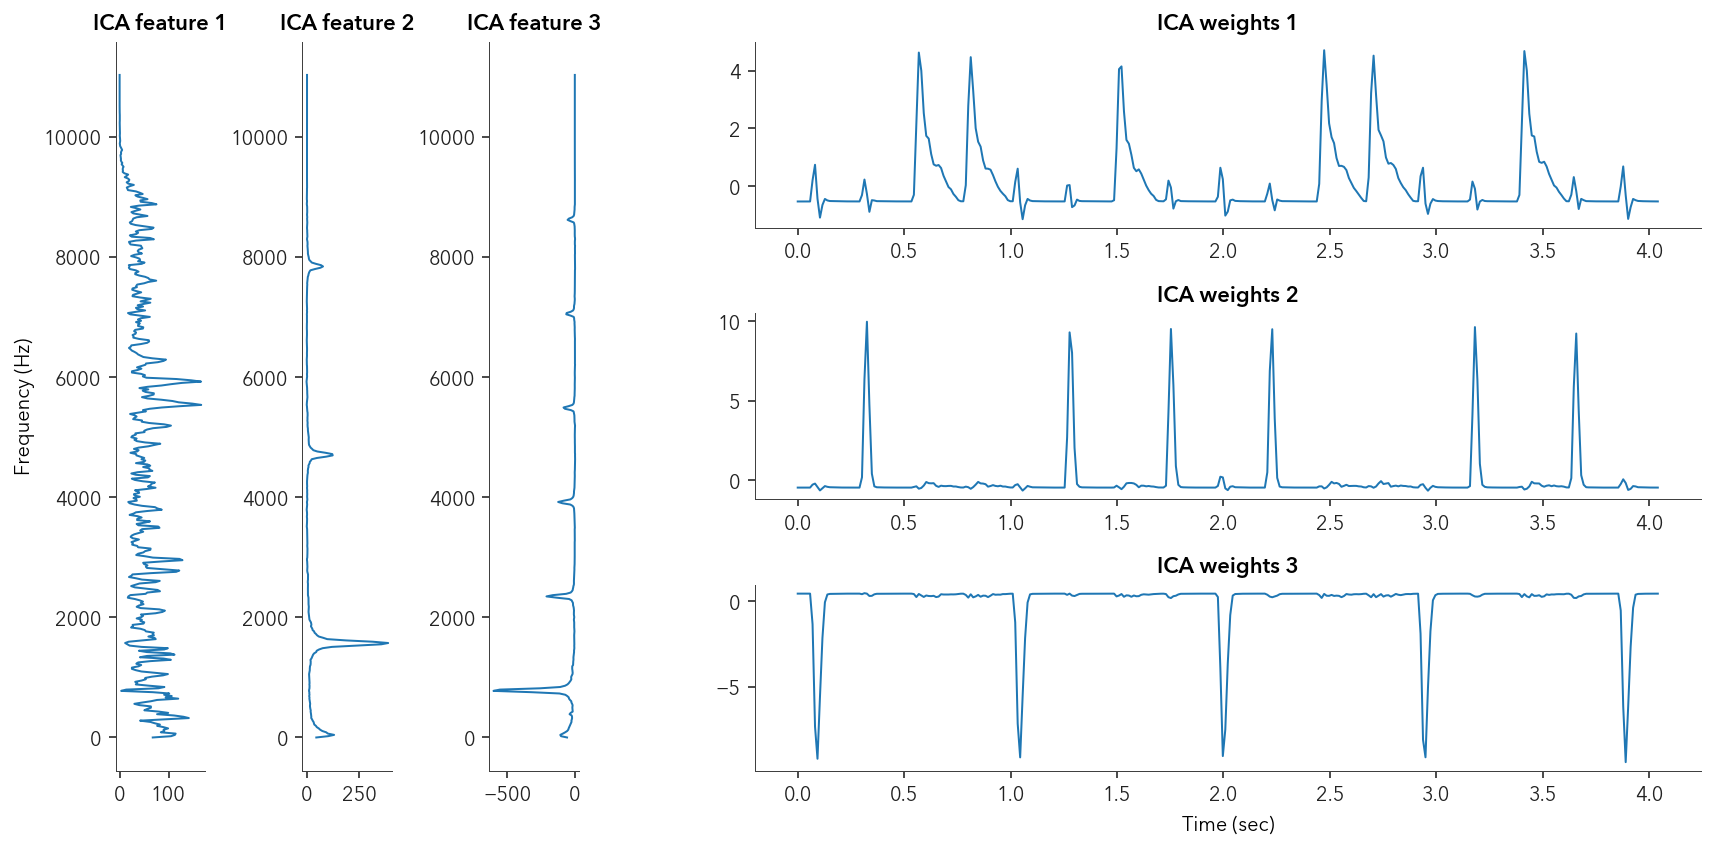

In [22]:
# Do ICA on the already whitened data
wi,xi = ica( xp)
    
# Get the inverse of the overall transform (PCA & ICA) to get the generating components
a = linalg.pinv( wi @ wp)

# Show me the features
subplot2grid( (1,9), (0,0)), plot( a[:,0], q), title( 'ICA feature 1'), ylabel( 'Frequency (Hz)')
subplot2grid( (1,9), (0,1)), plot( a[:,1], q), title( 'ICA feature 2')
subplot2grid( (1,9), (0,2)), plot( a[:,2], q), title( 'ICA feature 3')
    
# Show me the projection
subplot2grid( (3,3), (0,1), colspan=2), plot( t, xi[0]), title( 'ICA weights 1')
subplot2grid( (3,3), (1,1), colspan=2), plot( t, xi[1]), title( 'ICA weights 2')
subplot2grid( (3,3), (2,1), colspan=2), plot( t, xi[2]), title( 'ICA weights 3'), xlabel('Time (sec)')
tight_layout()

In the ICA features we see the three instrument spectra being represented perfectly, aside from the fact that the low tone is sign-inverted.  The corresponding weights provide a very good explanation of the input.  The third weight tells us how the low tone gets activated in time.  The weights are sign inverted since the feature itself is as well.  The product of these two vectors will reconstruct only the part of the sound that corresponds to that sound.  Likewise the second and first features describe how the other two instruments are activated in time.  This happens because the three instruments are statistically independent, and ICA strives to obtain a statistically independent feature set it gives us this satisfying description.

### NMF features

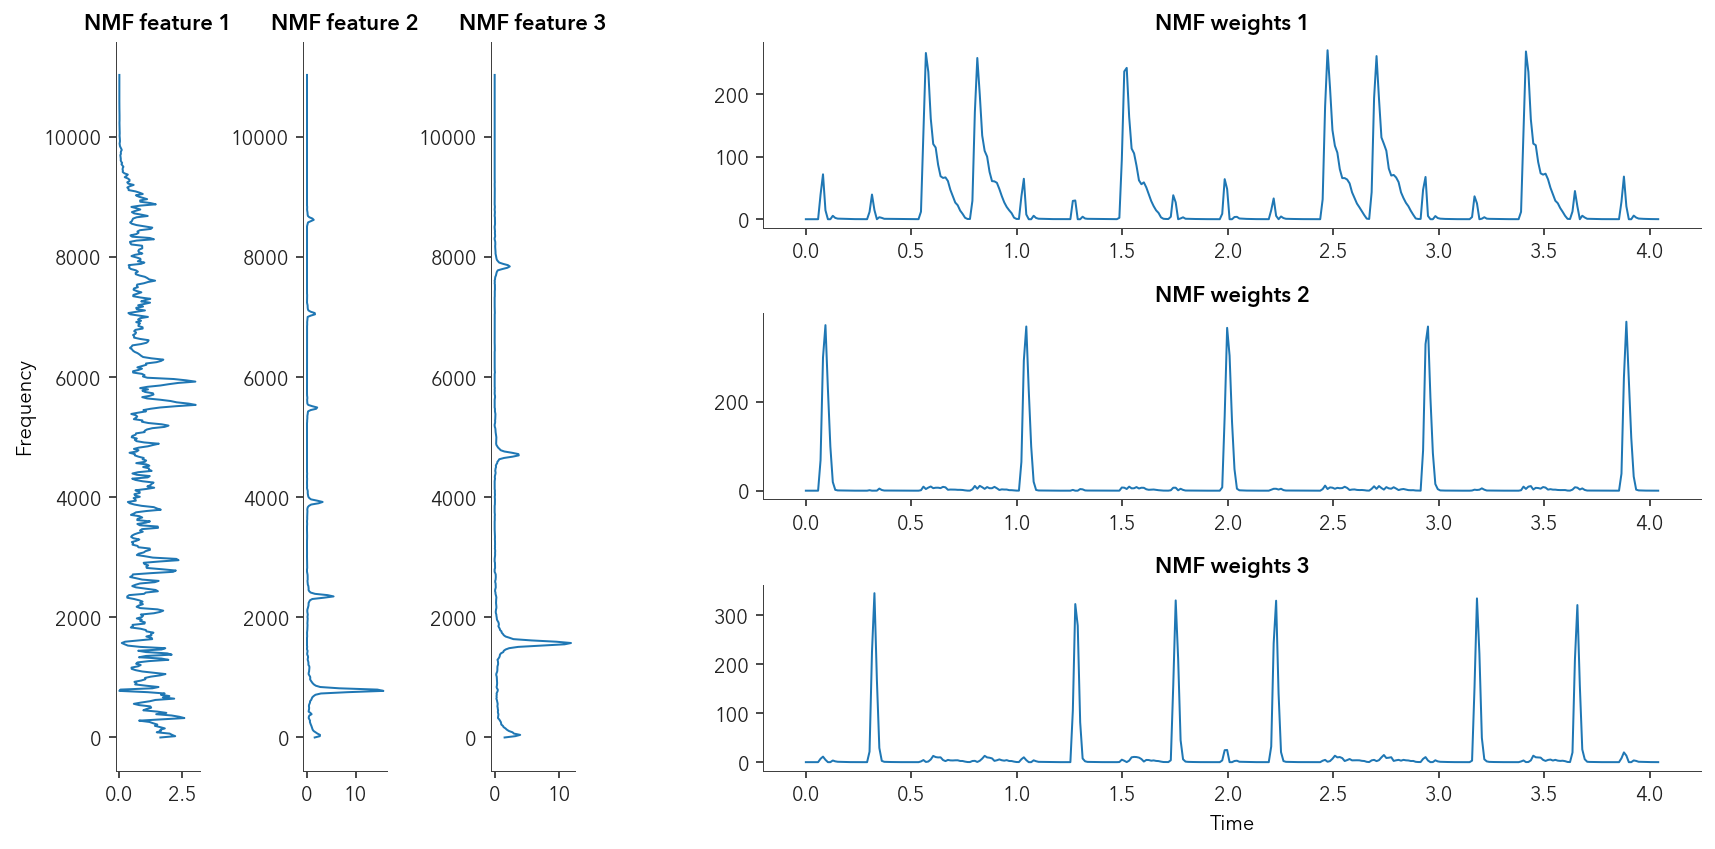

In [24]:
# Do NMF on the original input data
w,h = nmf( f, 3)

# Show me the bases
subplot2grid( (1,9), (0,0)), plot( w[:,0], q), title( 'NMF feature 1'), ylabel( 'Frequency')
subplot2grid( (1,9), (0,1)), plot( w[:,1], q), title( 'NMF feature 2')
subplot2grid( (1,9), (0,2)), plot( w[:,2], q), title( 'NMF feature 3')

# Show me the activations
subplot2grid( (3,3), (0,1), colspan=2), plot( t, h[0]), title( 'NMF weights 1')
subplot2grid( (3,3), (1,1), colspan=2), plot( t, h[1]), title( 'NMF weights 2')
subplot2grid( (3,3), (2,1), colspan=2), plot( t, h[2]), title( 'NMF weights 3'), xlabel( 'Time')
tight_layout()

The NMF features are very similar to the ICA features, only this time because of the non-negativity constraint we don’t see the sign-inversion we had with ICA.  This results in a very natural decomposition of the data where we can clearly see both the spectral and the temporal structure of the three instruments.

## Problem 2

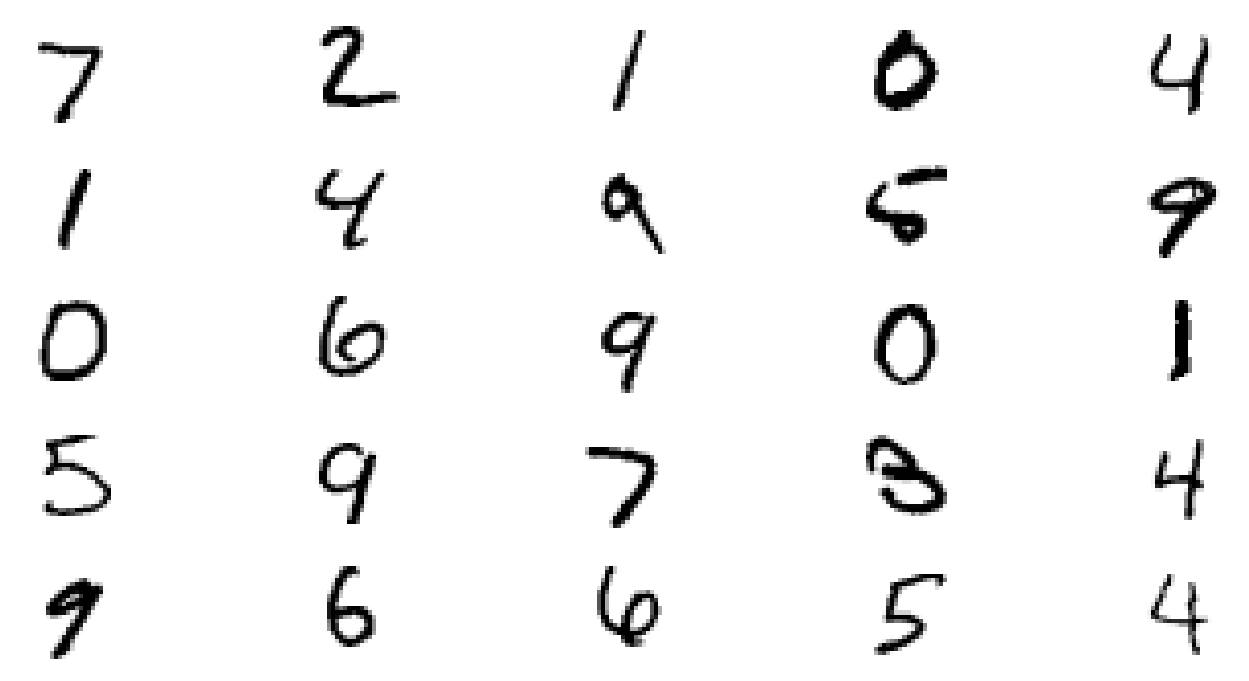

In [6]:
# Load the data
d = load( 'data/digits-labels.npz')['d']

# Function to show a digit
def digshow( x, diverging=False):
    if diverging:
        cmap = 'RdGy'
    else:
        cmap = 'binary'
    imshow( reshape( x, (28, 28), 'F'), cmap=cmap)    
    if diverging:
        v = amax( abs( x))
        clim( [-v,v])
    xticks( []), yticks( []), axis( 'off')

# Show me a few
for i in range( 25):
    subplot( 5, 5, i+1), digshow( d[:,i])

### Do PCA

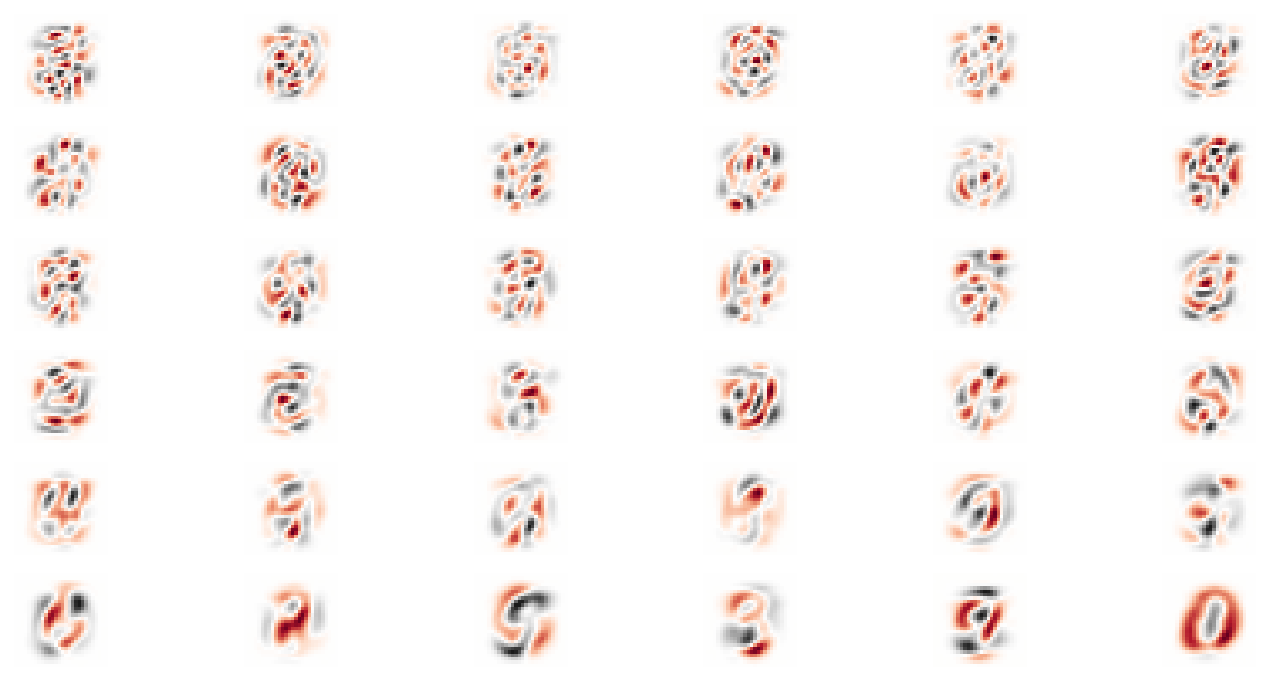

In [19]:
# As promised
wp,xp = pca( d, 36)

# Show me
for i in range( 36):
    subplot( 6, 6, i+1), digshow( wp[i], diverging=True)

The PCA features of the digits look similar to the eigenfaces example.  We see some ghostly images that capture a lot of the frequency information of the input.  The first component on the top left is the average of all the inputs, and as we move to the less important components we see higher frequency elements appearing, however they do so only where the digits tend to be (i.e., not around the edges of the image).

### Do ICA

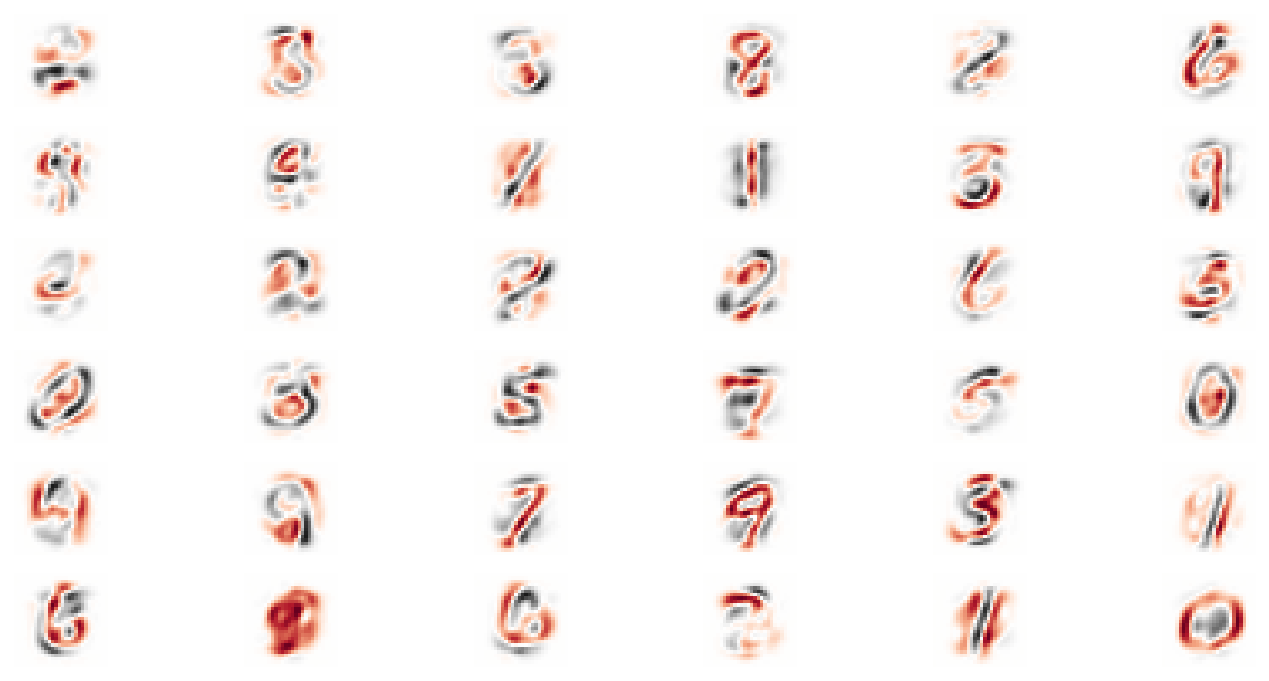

In [20]:
# Do ICA on the already whitened digits
wi,xi = ica( xp)

# Get the inverse of the overall transform (PCA & ICA) to get the generating components
a = linalg.pinv( wi @ wp)

# Show me
for i in range( 36):
    subplot( 6, 6, i+1), digshow( a[:,i], diverging=True)

Just as in the previous problem the ICA features look more like the actual independent elements in the input data (in this case characters).  But you can see that once again they can sometimes be sign-inverted.

### Do NMF

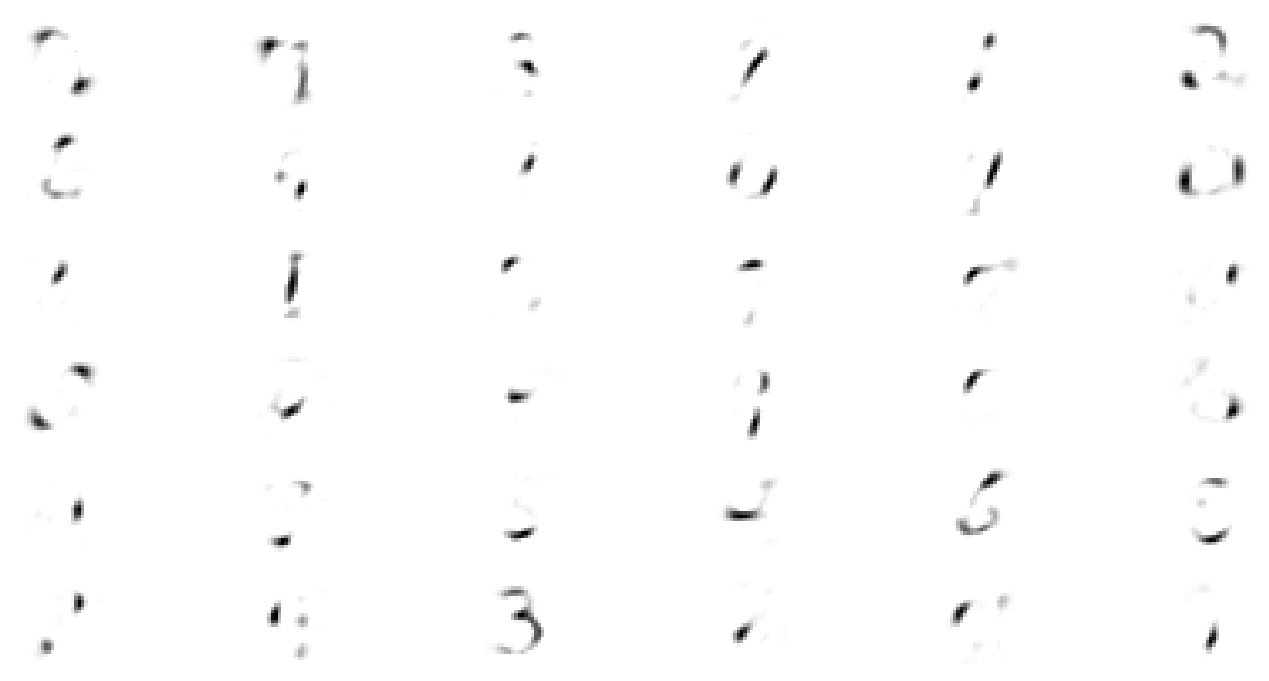

In [21]:
# Do NMF on the original input data
w,h = nmf( d, 36)

# Show me
for i in range( 36):
    subplot( 6, 6, i+1), digshow( w[:,i])

The NMF features are now much different.  We see that they focus on parts of the characters, such as individual strokes or segments.  Because NMF cannot use cross-cancellation like PCA and ICA, it was to resort to such a representation where the features have minimal overlap with each other, and they have to superimpose to form digits.

## Problem 3

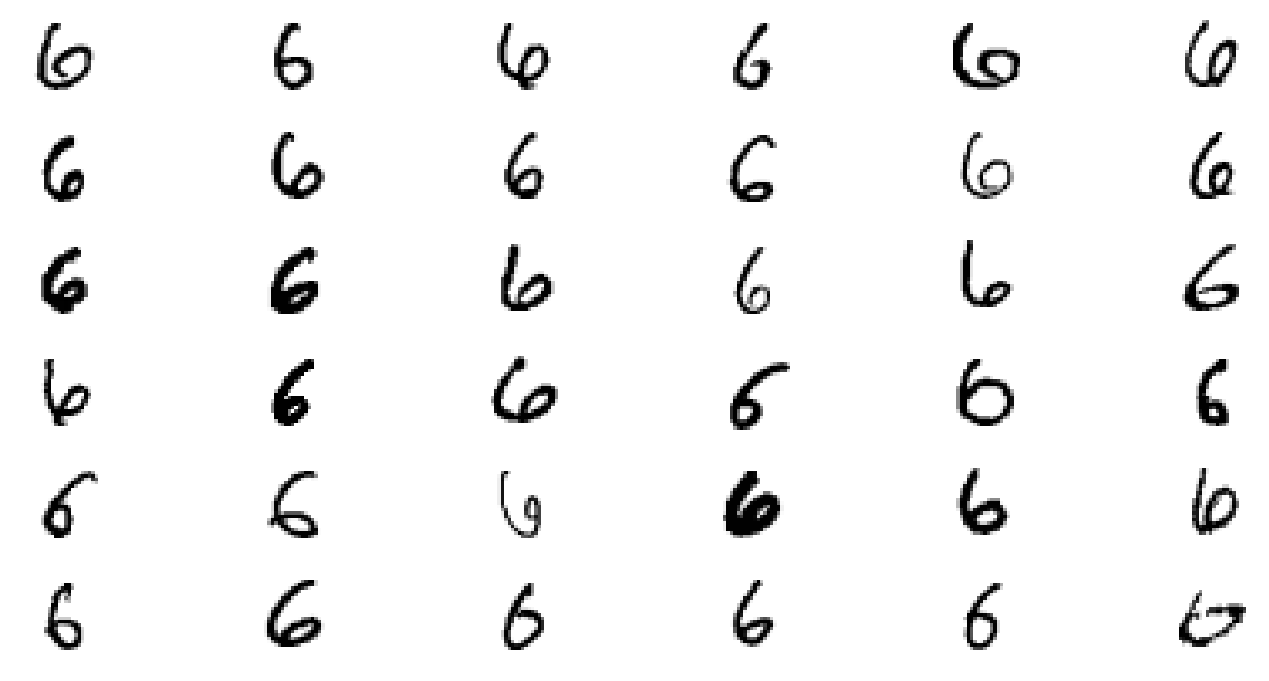

In [7]:
# Load the data
f = load( 'data/digits-labels.npz')
d,l = f['d'],f['l']

# Get the sixes only
dd = d[:,l==6]

# Show me some
for i in range( 36):
    subplot( 6, 6, i+1), digshow( dd[:,i])

### PCA of sixes

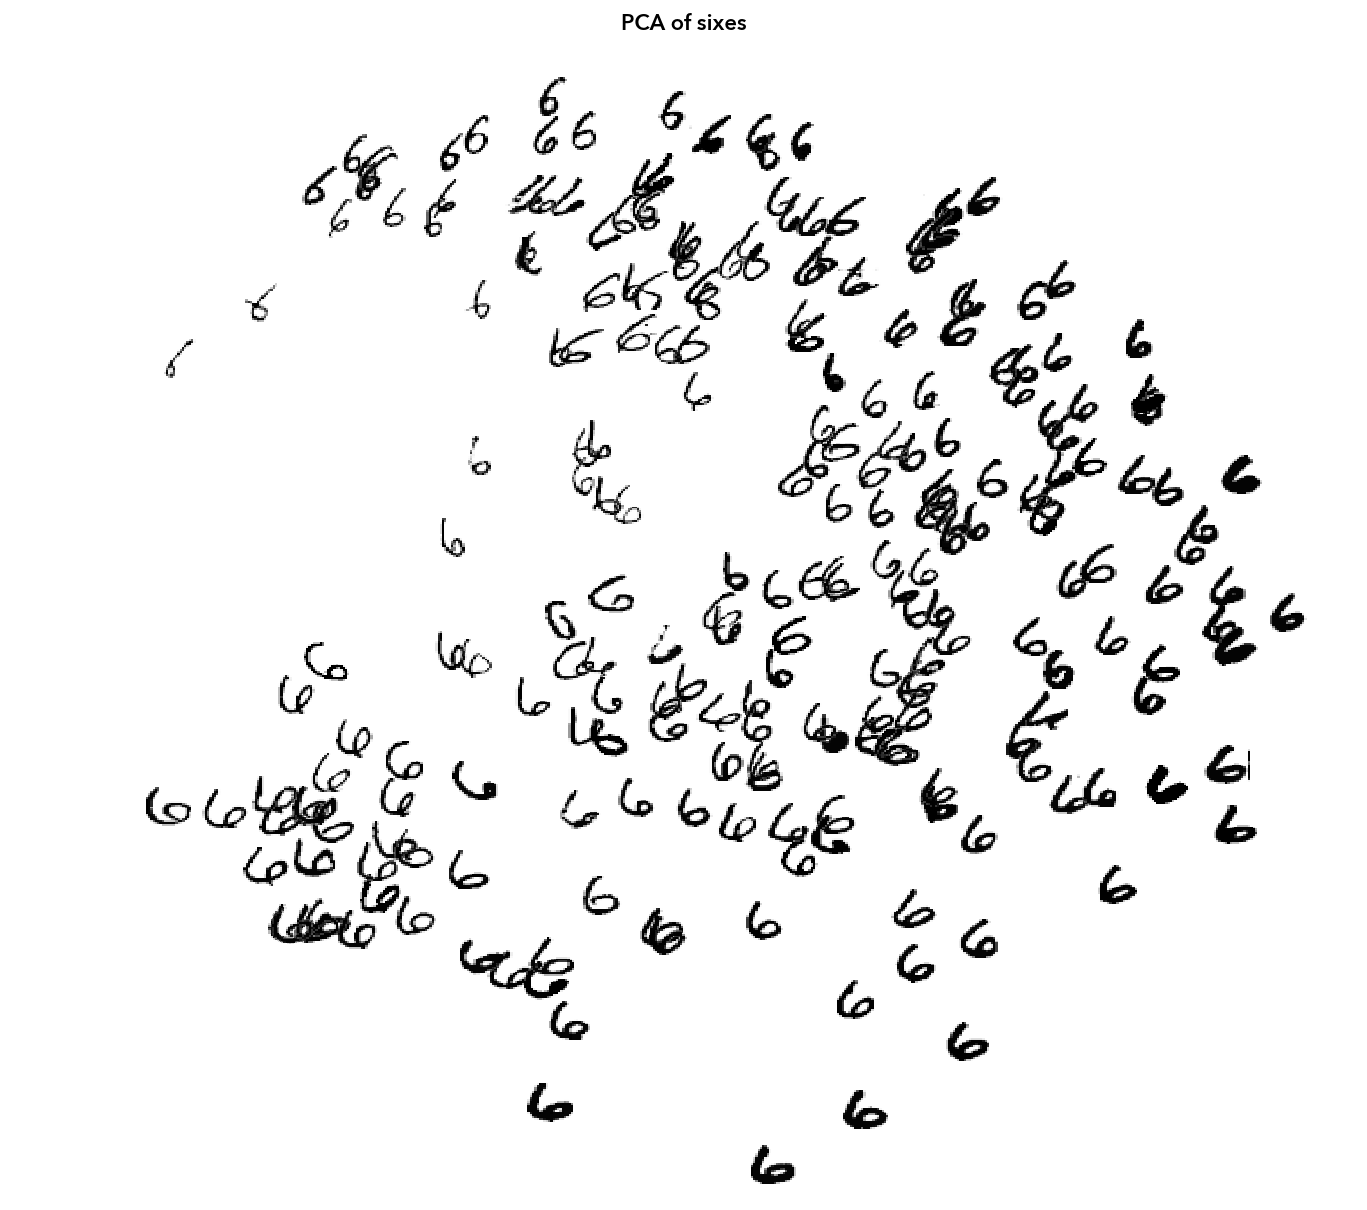

In [10]:
# Get 2d embedding using PCA
wp,xp = pca( dd, 2)

def digit_scatter( d, xp, ss):
    # Make a gray colormap where white is transparent
    ga = matplotlib.colors.LinearSegmentedColormap.from_list( 'Grays_a', [(1,1,1,0), (0,0,0,1)], N=128)

    # Show me the digits in their space
    figure( figsize=(12,12))
    sz = (array( [(amax( xp[0])-amin(xp[0])),(amax( xp[1])-amin(xp[1]))]))/20
    for i in range( 0, d.shape[1], ss):
        imshow( reshape( d[:,i], (28,28), 'F'), zorder=0, cmap=ga,
                extent=[xp[0,i], xp[0,i]+sz[0], xp[1,i], xp[1,i]+sz[1]])
    axis( [min( xp[0]), max( xp[0])+sz[0], min( xp[1]), max( xp[1])+sz[1]])
    axis( 'off')

digit_scatter( dd, xp, 4)
title( 'PCA of sixes');

If we plot the projection of our data through the principal components we get a crescent ordering in which one tip contains sixes oriented towards one side, and we gradually see that trend change as we move to the other tip where the sixes are oriented the other way. Although this is a good ordering of the primary variation in these digits, is it represented in a strange way (wrapped as a semicircle, even though this is a "one-dimensional" variation). This is because PCA strives for a unit covariance output, and being a linear operation it is not powerful enough to unravel this as a change over one axis. Additionally it seems that on that crescent shape the minor axis orders the sixes in terms of thickness, with light sixes on the inside, and darker ones on the outside.

## ISOMAP of sixes

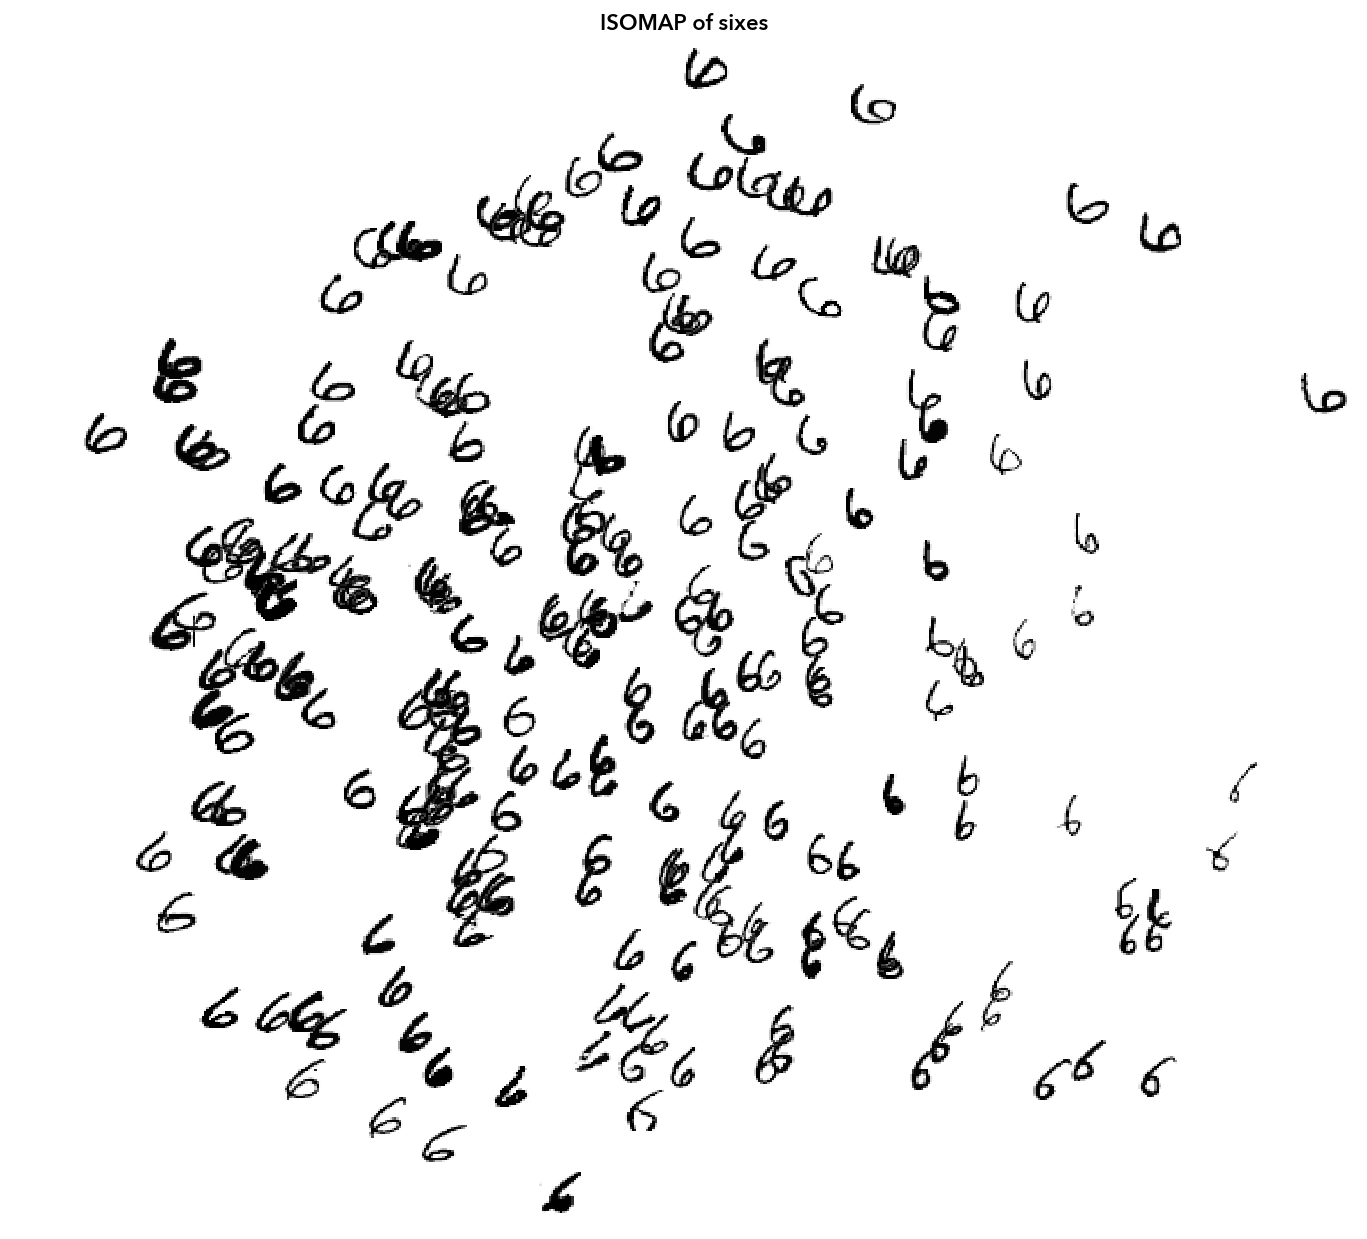

In [16]:
from scipy.sparse.linalg import eigsh

# ISOMAP
def isomap( x, n, k):
    # Get distance matrix
    d = sqrt( real( sum(x*x, axis=0, keepdims=True).T + \
               sum(x*x, axis=0, keepdims=True) -2*(x.T@x)).clip( 0))

    # Keep k closest neighbors only
    j = argsort( d, axis=1)
    for i in range( d.shape[1]):
        d[i,j[i,k+1:]] = Inf

    # Make sure we're symmetric
    d = minimum( d, d.T)

    # Run Floyd's algorithm to find geodesic affinities
    for i in range( x.shape[1]):
        d = minimum( d, d[:,i][:,None] + d[i,:][None,:])
    
    # Square and center
    d = d**2
    d = -.5 * (d - mean( d, axis=1, keepdims=True) - mean( d, axis=0, keepdims=True) + mean( d))
    
    # Get eigenvectors
    return eigsh( d, k=n)[1].T

# Do it
xp = isomap( dd, n=2, k=6)

digit_scatter( dd, xp, 4)
title( 'ISOMAP of sixes');

With the manifold analysis we obtain a cleaner topology.  Now we can clearly see the ordering of the sixes, one axis (up-down) correlates with the orientation of the ascender, whereas the other (left-right) correlates with stroke thickness. Both are much more linearly represented than with PCA.